# Uncertainty from imputation

### Are you taking it into account in your predictions?

A few weeks ago, the [course in handling missing data in R](https://datacamp.com/courses/handling-missing-data-with-imputations-in-r) that I've been developing with DataCamp went live. From the feedback I got from the students so far it follows that the part of the course they benefit from the most is about how to incorporate the uncertainty from imputation into modeling. In this article, I will discuss it briefly in the context of making predictions with machine learning models.

To demonstrate the topic, we will analyze the *biopics* data set from the *fivethirtyeight* R package. We will be working with a small and processed version of the original data. Let's take a look at it.

In [464]:
library(readr)
library(dplyr)
library(ranger)
library(missForest)
library(VIM)
library(boot)
library(ggplot2)

biopics <- read_csv("biopics.csv", col_types = cols())
biopics[colnames(biopics) != "earnings"] <- prodNA(biopics[colnames(biopics) != "earnings"], 0.1)
biopics <- filter(biopics, !is.na(earnings))
biopics$earnings = log(biopics$earnings)
biopics <- select(biopics, -sub_race, -non_white)

In [465]:
head(biopics)

country,year,earnings,sub_num,sub_type,sub_sex
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
US/UK,2013,4.0377742,1,Other,Male
US/UK,2010,2.9069011,1,Athlete,Male
US,1998,-0.6217572,1,NA,Male
US,2008,4.3969152,1,Other,Male
UK,2002,0.1222176,1,Musician,Male
US,2013,4.5538769,1,Athlete,Male


The *biopics* data contain some information on a number of biographical movies. The features include the movie's country of production, release year, log earnings at the box offices, number of subjects featured in the movie, the type of subjects or reason for recognition, and their gender. The task here is to predict the log-earnings based on the remaining features. We are considering shooting our very own movie. It will be released in the US next year and it will tell a story of a single character: a female athlete. We would like to know how much we are likely to earn.

In [466]:
new_data <- c("US", 2021, 1, "Athlete", "Female")
names(new_data) <- colnames(biopics)[colnames(biopics) != "earnings"]
new_data <- bind_rows(new_data)

Unfortunately, the data set is not complete: there are a number of missing values in each feature column.

In [467]:
biopics %>% is.na() %>% colSums()

country     year earnings  sub_num sub_type  sub_sex 
      38       39        0       47       45       46

One way to go about it is to impute (i.e. fill-in) the missing data in some way and once the data are complete, feed them to the model. This is actually what most people do, so let's do it too. We will impute the data with hot-deck imputation from the `VIM` package and train a random forest using the `ranger` package. If you are interested in how hot-deck works, what other imputation methods are available, and how to tweak them to work well, feel free to check out [my course](https://datacamp.com/courses/handling-missing-data-with-imputations-in-r). 

In [468]:
biopics_imp <- hotdeck(biopics, imp_var = FALSE)
rf_model <- ranger(earnings ~ ., data = biopics_imp)
single_pred <- predict(rf_model, data = new_data)$prediction
print(single_pred)

[1] 0.01210784


We have obtained a single prediction of 0.01210784. Once we invert the log-transformation, we will see that our movie is expected to earn exp(0.01210784) ≈ $1m. We are millionaires! But how sure can we be about it?

The prediction above completely ignores the fact that the random forest model was fit to imputed data. **It is important to note that the imputed values are not set in stone. They are just estimates and estimates come with uncertainty.** To express it in the statistical jargon: the imputed values are estimated based on the observed ones, and the latter are drawn from some population; hence, there is double uncertainty involved: the uncertainty associated with data sampling and uncertainty coming from the imputation method. One would be unwise to act upon such an uncertain prediction!

**While there is no way whatsoever to convert uncertainty into certainty in statistics, there are ways to capture the uncertainty and take it into account when acting upon models' predictions.** One way to this in our case is by bootstrapping. What we need to do is to take a bootstrap sample from the original, incomplete data. This means we are sampling rows of the data with replacement. Then, we impute the bootstrap sample, build a model on the imputed data, and finally make the prediction. We repeat the procedure many, say 1000, times, taking different, random bootstrap samples. As a result, we obtain a distribution of predicted earnings for our planned movie and this distribution captures the uncertainty from imputation.

This is pretty easy to implement in R thanks to the `boot` package. We only need to define a function that receives the original data and the indices of the to-be-sampled rows as inputs. The function should then select these rows, impute the bootstrap sample, train a model, and return the prediction. All that's left to do is to pass this custom function to the `boot` function.

In [470]:
bootstrap_impute_predict <- function(data, indices) {
    data_boot <- data[indices, ]
    data_imp <- hotdeck(data_boot, imp_var = FALSE)
    random_forest_model <- ranger(earnings ~ ., data = data_imp)
    pred <- predict(random_forest_model, data = new_data)$prediction
return(pred)
}

boot_pred <- boot(biopics, statistic=bootstrap_impute_predict, R=1000)
print(boot_pred)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = biopics, statistic = bootstrap_impute_predict, R = 1000)


Bootstrap Statistics :
      original    bias    std. error
t1* -0.1653522 0.2951796   0.5529813


What this output tells us is that our original, single prediction of 0.01210784 is somewhat biased compared to the mean of the bootstrapped distribution and that this distribution has a pretty large standard error, signifying considerable uncertainty.

Let's now compute the 95% confidence interval for our prediction.

In [471]:
boot_ci <- boot.ci(boot_pred, conf = 0.95, type = "perc")
print(boot_ci)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_pred, conf = 0.95, type = "perc")

Intervals : 
Level     Percentile     
95%   (-1.0155,  1.1770 )  
Calculations and Intervals on Original Scale


So, we are 95% sure our movie will log-earn something between -1.02 and 1.18. Converting it back to dollars leaves us with the range from $\$362k$ and $\$3.2m$. Quite a spread. Let's plot the distribution of the prediction, the single prediction, and the confidence interval all in one graph.

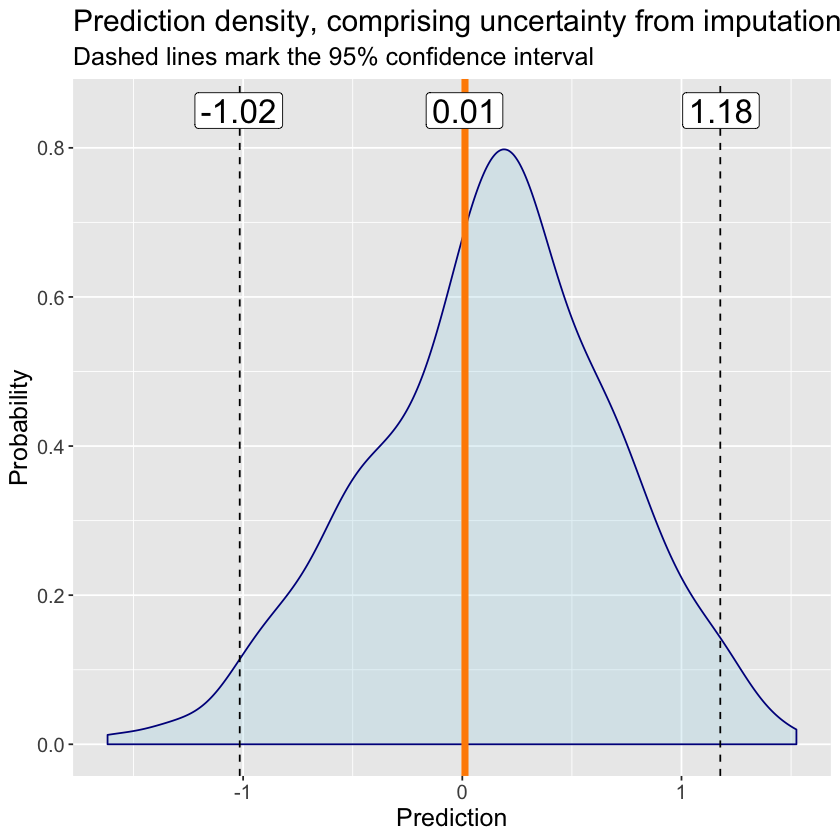

In [473]:
ggplot() +
    geom_density(aes(boot_pred$t), color="darkblue", fill="lightblue", alpha = 0.3) +
    geom_vline(xintercept = single_pred, col = "darkorange", size=2) +
    geom_vline(xintercept = boot_ci$perc[4], linetype = "dashed") +
    geom_vline(xintercept = boot_ci$perc[5], linetype = "dashed") +
    geom_label(aes(label = round(single_pred, 2), y = .85, x = round(single_pred, 2)), size = 7) +
    geom_label(aes(label = round(boot_ci$perc[4], 2), y = .85, x = round(boot_ci$perc[4], 2)), size = 7) +
    geom_label(aes(label = round(boot_ci$perc[5], 2), y = .85, x = round(boot_ci$perc[5], 2)), size = 7) +
    labs(title = "Prediction density, comprising uncertainty from imputation",
         subtitle = "Dashed lines mark the 95% confidence interval",
         x = "Prediction",
         y = "Probability") +
    theme(text = element_text(size=15))

The orange line at 0.01 denotes the prediction we got from training a single model on the data imputed only once. This single-shot didn't even give us the most likely outcome! This is due to the bias which becomes clear from the visualization: the most likely earnings are at the peak of the distribution somewhat to the right from our initial prediction. And then: look at how wide the distribution is!

Shooting the movie might still be worth it, but depending on your risk aversion, you might want to take precautions in case it doesn't pay off, which is not that unlikely.

Thanks for reading. If you are interested in learning more about missing data, various imputation methods and other ways of incorporating imputation uncertainty into modeling, check out [my DataCamp course](https://datacamp.com/courses/handling-missing-data-with-imputations-in-r). You can also find my other articles [here](https://michaloleszak.github.io/blog/).